# WISE BPIC 2019 – From Event Log to Actionable Insights

This notebook-style markdown file rewrites the original `BPIC_2019.ipynb`
into a more guided, business-facing analysis of the BPI Challenge 2019
Purchase-to-Pay (P2P) log, using the modular WISE helper functions provided
in `wise_bpic19_modular.py`.fileciteturn9file0

The goals are to:

- load and understand the BPIC'19 log,
- explore process models for the **four main process types**,
- engineer useful **case-level features** (lead times, rework, automation, …),
- compute **WISE scores** per case and slice,
- visualise where **problems concentrate** in the actual processes,
- produce outputs that are close to decision-ready for business stakeholders.

> You can convert this file to a Jupyter notebook with  
> `jupytext --to ipynb WISE_BPIC19_Analysis.md`.

---

## 0. Imports and configuration

We rely on the modular helpers in
`wise_bpic19_modular.py`, which wrap loading, feature engineering,
WISE scoring, and slice aggregation.fileciteturn9file0

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from wise.analysis.wise_bpic19_modular import (
    load_settings_and_paths,
    load_log,
    subset_by_item_category,
    build_case_features,
    compute_wise_case_scores,
    enrich_case_full,
    aggregate_slices,
    show_for_category,
)

sns.set_theme(style="whitegrid")

---

## 1. Load settings and the BPIC'19 log

The `settings.json` file (used by WISE) specifies which columns are used as
case identifier, activity name, and timestamp, as well as paths to the data
and norm files. The helper `load_settings_and_paths` resolves those.

In [2]:
settings, paths = load_settings_and_paths()
#make function to save dataframes to output_path
def save_df(df: pd.DataFrame, filename: str):
    output_path = Path(settings["output_path"])
    output_path.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path / filename, index=False)
    
settings, paths

({'data_path': 'data/BPI_Challenge_2019.csv',
  'norm_path': 'data/WISE_BPIC_2019_norm.json',
  'reports_path': 'path/to/your/reports',
  'output_path': 'data/results_BPIC_2019',
  'case_id_col': 'case:concept:name',
  'activity_col': 'concept:name',
  'timestamp_col': 'time:timestamp',
  'default_view': 'Finance',
  'SLICE_COLS': ['case_Company',
   'case_Spend_area_text',
   'case_Purch._Doc._Category_name'],
  'CASE_COLS': {'CASE_ID_COL': 'case concept:name',
   'ACTIVITY_COL': 'event concept:name',
   'TIMESTAMP_COL': 'event time:timestamp'}},
 {'settings_path': PosixPath('/Users/ula/code/PhD/WISE/WISE/Untitled/settings.json'),
  'data_path': PosixPath('/Users/ula/code/PhD/WISE/WISE/Untitled/data/BPI_Challenge_2019.csv'),
  'norm_path': PosixPath('/Users/ula/code/PhD/WISE/WISE/Untitled/data/WISE_BPIC_2019_norm.json'),
  'output_path': PosixPath('/Users/ula/code/PhD/WISE/WISE/Untitled/data/results_BPIC_2019')})

In [3]:
case_id_col = settings["CASE_COLS"]["CASE_ID_COL"]
act_col     = settings["CASE_COLS"]["ACTIVITY_COL"]
ts_col      = settings["CASE_COLS"]["TIMESTAMP_COL"]

df = load_log(paths["data_path"], settings, parse_dates=True)
df.head()

[INFO] Loaded log from /Users/ula/code/PhD/WISE/WISE/Untitled/data/BPI_Challenge_2019.csv: 1,595,923 events, 251,734 cases


/Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/analysis/wise_bpic19_modular.py:140: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S.%f format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")


,eventID,case Spend area text,case Company,case Document Type,case Sub spend area text,case Purchasing Document,case Purch. Doc. Category name,case Vendor,case Item Type,case Item Category,...,case Name,case GR-Based Inv. Verif.,case Item,case concept:name,case Goods Receipt,event User,event org:resource,event concept:name,event Cumulative net worth (EUR),event time:timestamp
0,65781719105536,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,20,4507004931_00020,True,NONE,NONE,Vendor creates invoice,68.0,1948-01-26 23:59:00
1,65777424138241,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,10,4507004931_00010,True,NONE,NONE,Vendor creates debit memo,325.0,1948-01-26 23:59:00
2,65777424138240,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,10,4507004931_00010,True,NONE,NONE,Vendor creates invoice,325.0,1948-01-26 23:59:00
3,65794604007424,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,50,4507004931_00050,True,NONE,NONE,Vendor creates invoice,102.0,1948-01-26 23:59:00
4,65794604007425,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,50,4507004931_00050,True,NONE,NONE,Vendor creates debit memo,102.0,1948-01-26 23:59:00


**Business interpretation.**  
At this point we know how many events and cases are in the log, and we have
verified that the timestamp column is parsed as a proper datetime. For BPIC'19
we expect roughly **1.6M events** and **251k PO line-item cases**.

---

## 2. Understand log structure and process types

The challenge description states that each Purchase Order (PO) line item is
assigned to one of four **item categories** matching different P2P flows:

1. 3-way match, **invoice after GR**  
2. 3-way match, **invoice before GR**  
3. **2-way** match (no GR)  
4. **Consignment** (GR but no invoice in this log)

We can inspect the distribution of item categories and related attributes.

In [4]:
cols_of_interest = [
    "case Item Category",
    "case GR-Based Inv. Verif.",
    "case Goods Receipt",
    "case Document Type",
    "case Company",
    "case Spend area text",
    "case Spend classification text",
    "case Source",
]

[c for c in cols_of_interest if c in df.columns]

['case Item Category',
 'case GR-Based Inv. Verif.',
 'case Goods Receipt',
 'case Document Type',
 'case Company',
 'case Spend area text',
 'case Spend classification text',
 'case Source']

In [5]:
for col in ["case Item Category", "case Document Type", "case Spend area text"]:
    if col in df.columns:
        print("\n", col)
        display(df[col].value_counts(dropna=False).head(10))


 case Item Category


case Item Category
3-way match, invoice before GR    1234708
3-way match, invoice after GR      319233
Consignment                         36084
2-way match                          5898
Name: count, dtype: int64


 case Document Type


case Document Type
Standard PO          1539913
Framework order        33649
EC Purchase order      22361
Name: count, dtype: int64


 case Spend area text


case Spend area text
Packaging                 583981
Sales                     360774
Logistics                 253565
Trading & End Products    126756
Additives                  95499
CAPEX & SOCS               40074
Latex & Monomers           27007
NaN                        16294
Others                     15419
Solvents                   13889
Name: count, dtype: int64

**Business questions to keep in mind.**

- Which **spend areas** (Logistics, Marketing, Services, …) exist, and how large
  are they?
- Which **item categories** (3-way, 2-way, consignment) dominate in each spend
  area?
- How many **companies** exist in the log and what is their relative size?
- Which **source systems** are in play?

These attributes will soon become **slice dimensions** (e.g. `Company ×
Spend area × Item category`) in WISE, so it is useful to mentally connect
them to possible KPIs:

- throughput & blocked invoice days (Order/Lag),
- 3-way match success & mismatch rates (Presence/Balance),
- rework & late changes (Singularity/Exclusion),
- touchless rate (automation ratios).

---

## 3. Choose a process type and inspect its models

WISE is evaluated per log subset; here we follow the challenge and focus on
one item category at a time. For example, start with:

- **3-way match, invoice after GR** (classic 3-way).

In [6]:
category_col = "case Item Category"
process_type = "3-way match, invoice after GR"  # adjust to your log labels

df_example = subset_by_item_category(
    df=df,
    cat_value=process_type,
    category_col=category_col,
    case_id_col=case_id_col,
)

save_df(df_example, "df_subset_3-way_match_invoice_after_GR.csv")

df_example.head()

[INFO] Subset '3-way match, invoice after GR': 319,233 events, 15,182 cases


,eventID,case Spend area text,case Company,case Document Type,case Sub spend area text,case Purchasing Document,case Purch. Doc. Category name,case Vendor,case Item Type,case Item Category,...,case Name,case GR-Based Inv. Verif.,case Item,case concept:name,case Goods Receipt,event User,event org:resource,event concept:name,event Cumulative net worth (EUR),event time:timestamp
19,6481105649664,Logistics,companyID_0000,Framework order,Road Packed,4507000647,Purchase order,vendorID_0307,Service,"3-way match, invoice after GR",...,vendor_0298,True,10,4507000647_00010,True,NONE,NONE,Vendor creates debit memo,848704.0,2001-01-23 23:59:00
21,515396075520,Marketing,companyID_0000,EC Purchase order,Digital Marketing,2000000097,Purchase order,vendorID_0052,Service,"3-way match, invoice after GR",...,vendor_0052,True,1,2000000097_00001,True,NONE,NONE,Vendor creates debit memo,11353.0,2001-02-23 23:59:00
24,398439821082624,Logistics,companyID_0000,Framework order,Sea,4507027474,Purchase order,vendorID_1442,Service,"3-way match, invoice after GR",...,vendor_1377,True,10,4507027474_00010,True,NONE,NONE,Vendor creates debit memo,372741.0,2001-04-10 23:59:00
34,188677913313280,Marketing,companyID_0000,EC Purchase order,Market Research,2000013555,Purchase order,vendorID_0089,Service,"3-way match, invoice after GR",...,vendor_0089,True,1,2000013555_00001,True,NONE,NONE,Vendor creates invoice,15022.0,2001-04-27 23:59:00
43,536454300172288,Sales,companyID_0000,Standard PO,Products for Resale,4507037128,Purchase order,vendorID_0236,Standard,"3-way match, invoice after GR",...,vendor_0231,True,310,4507037128_00310,True,NONE,NONE,Vendor creates invoice,42.0,2008-06-19 23:59:00


We can quickly inspect the discovered process model for this subset using
pm4py (this opens interactive visualisations in Jupyter):


[PROCESS MODEL] Category: 3-way match, invoice after GR
Events: 319,233, Cases: 15,182


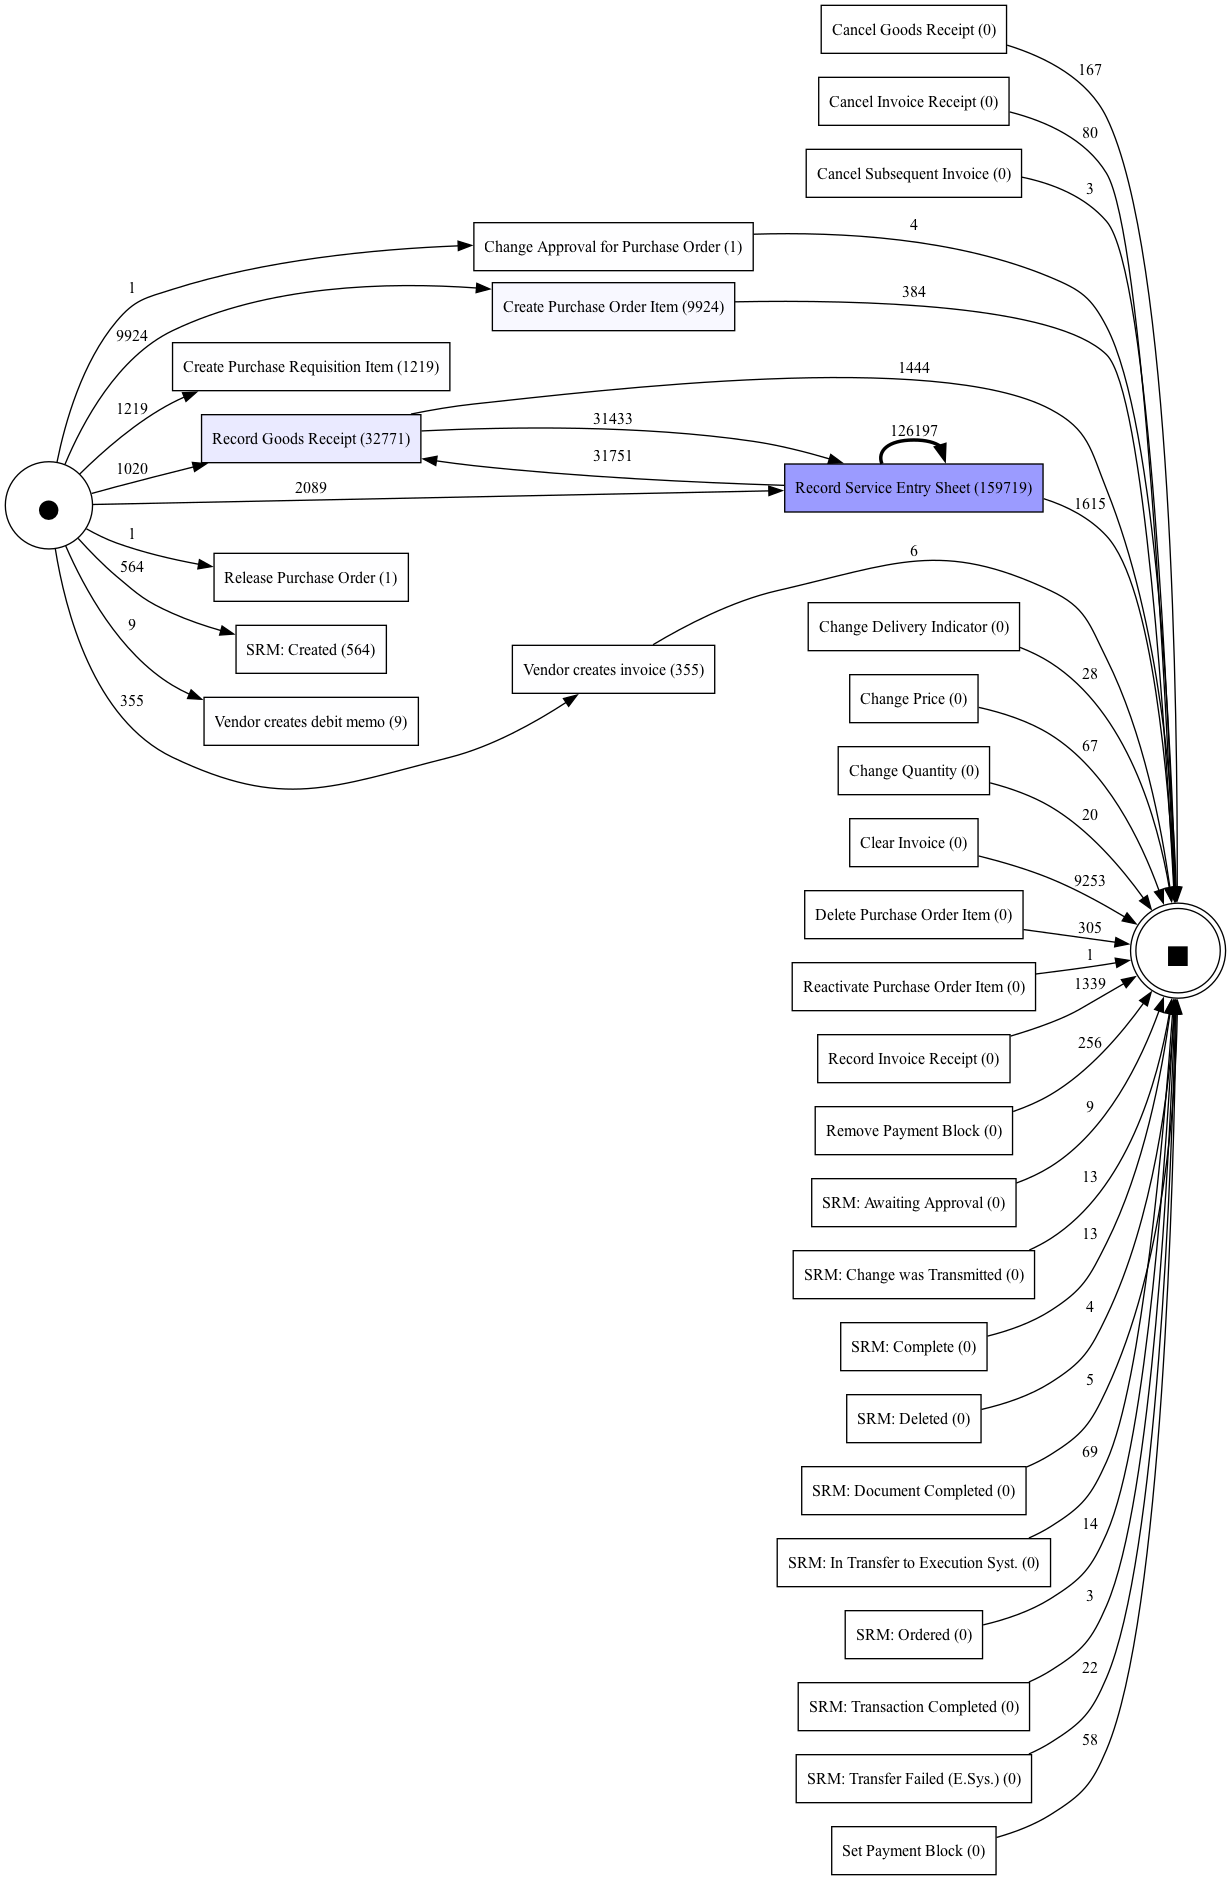

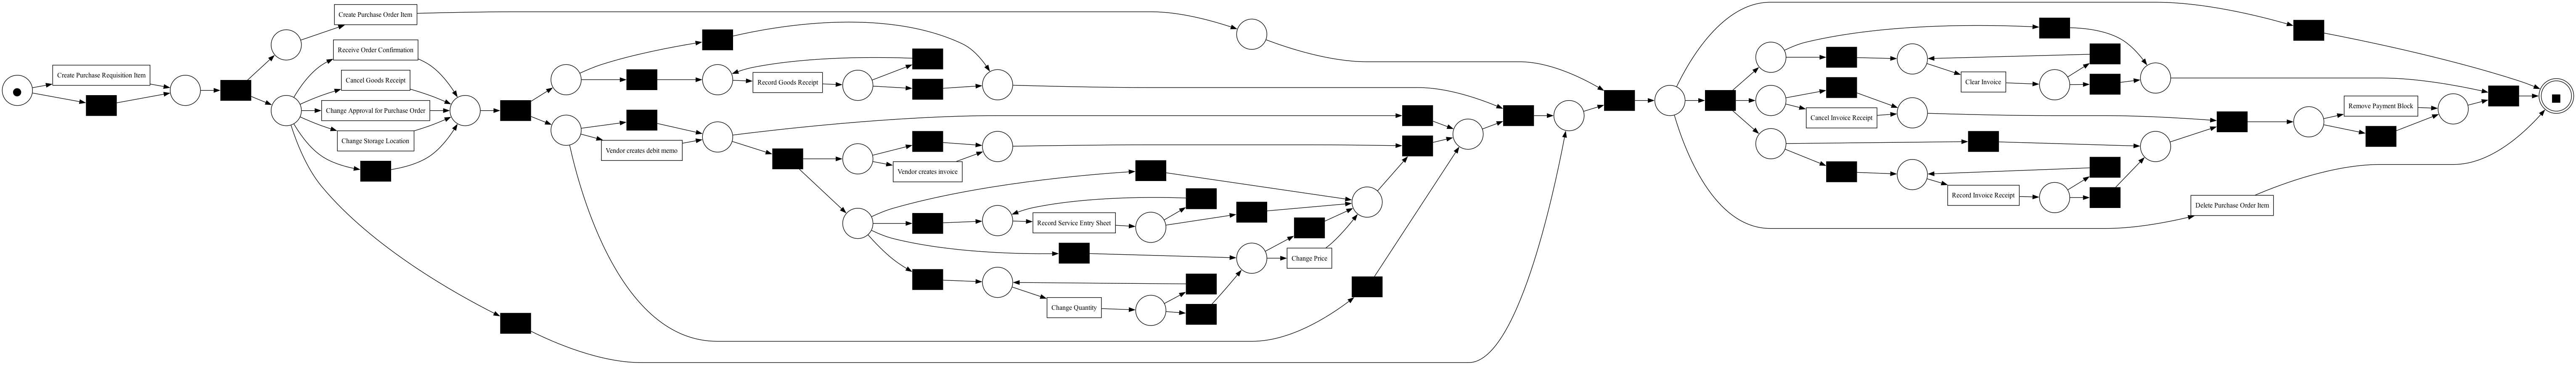

In [7]:
show_for_category(
    df_subset=df_example,
    category_name=process_type,
    case_id_col=case_id_col,
    act_col=act_col,
    ts_col=ts_col,
    percentile=0.6,
)

**What to look for (business-wise).**

- Does the main flow look like **Create PO Item → GR → INV → CLEAR**?  
- Are there many loops around GR (multiple goods receipts) or price changes?  
- Do you see activities that only occur in certain spend areas (e.g. special
  logistics steps)?  
- Does the model look more complex for some companies/spend areas than others?

These observations help you define **layered norm constraints** for WISE
(L1–L5) that reflect how the process *should* behave for this process type.

---

## 4. Build case-level features for this process type

The helper `build_case_features` constructs a rich set of case-level
features for the given subset:

- lead times: `po_to_gr_days`, `gr_to_inv_days`, `inv_to_clear_days`,
- counts of GR/INV/CLEAR events and price changes,
- number of users involved, total number of events,
- calendar features: day-of-week, month,
- automation heuristic: `auto_ratio` (share of events performed by batch users),
- multiplicity features: repeated activities and repeated change activities,
- a simple **KMeans cluster** over behaviour/complexity.

In [8]:
feat = build_case_features(
    df_example=df_example,
    case_id_col=case_id_col,
    act_col=act_col,
    ts_col=ts_col,
)
save_df(feat, "case_features_3-way_match_invoice_after_GR.csv")
feat.head(20)

,case concept:name,first_po,first_gr,first_inv,first_clear,po_to_gr_days,gr_to_inv_days,inv_to_clear_days,n_events,n_gr,...,n_manual_events,auto_ratio,has_gr,has_inv,has_clear,n_multi_activities,sum_multi_events,n_multi_change_activities,sum_multi_change_events,cluster
0,2000000001_00001,2018-01-03 10:49:00,2018-01-16 13:09:00,2018-01-16 15:44:00,2018-03-08 13:21:00,13.0,0.0,50.0,15,1,...,15,0.0,True,True,True,1,2,0,0,0
1,2000000002_00001,2018-01-04 15:17:00,2018-02-06 15:53:00,2018-08-16 12:41:00,2018-08-16 15:03:00,33.0,190.0,0.0,18,2,...,18,0.0,True,True,True,3,6,0,0,0
2,2000000005_00002,2018-01-08 11:09:00,NaT,NaT,NaT,NaN,NaN,NaN,8,0,...,8,0.0,False,False,False,0,0,0,0,1
3,2000000006_00001,2018-01-08 12:33:00,2018-01-09 10:04:00,2018-01-09 12:59:00,2018-02-23 12:14:00,0.0,0.0,44.0,15,1,...,15,0.0,True,True,True,1,2,0,0,0
4,2000000008_00001,2018-01-08 16:36:00,2018-01-15 12:53:00,2018-01-17 15:49:00,2018-02-22 16:18:00,6.0,2.0,36.0,13,1,...,13,0.0,True,True,True,0,0,0,0,0
5,2000000009_00001,2018-01-09 14:14:00,2018-03-08 08:27:00,2018-03-09 16:47:00,2018-03-15 14:13:00,57.0,1.0,5.0,13,1,...,13,0.0,True,True,True,0,0,0,0,0
6,2000000010_00001,2018-01-09 16:30:00,2018-01-10 16:11:00,2018-01-16 10:49:00,2018-03-29 15:11:00,0.0,5.0,72.0,38,3,...,38,0.0,True,True,True,13,35,1,2,2
7,2000000011_00001,2018-01-09 17:54:00,2018-01-11 11:10:00,2018-04-11 16:45:00,2018-04-12 14:08:00,1.0,90.0,0.0,15,1,...,15,0.0,True,True,True,1,2,0,0,0
8,2000000013_00001,2018-01-10 16:40:00,2018-01-16 14:27:00,2018-01-24 17:15:00,2018-02-15 14:51:00,5.0,8.0,21.0,13,1,...,13,0.0,True,True,True,0,0,0,0,0
9,2000000014_00001,2018-01-11 16:41:00,2018-02-16 16:47:00,2018-02-19 14:20:00,2018-03-01 14:06:00,36.0,2.0,9.0,35,5,...,35,0.0,True,True,True,6,27,0,0,0


We get one row per case, with columns that can be used both for:

- **diagnostic plots** (e.g. distributions of lead times), and
- **additional slice dimensions** (clusters, automation levels) in WISE.

### 4.1. Quick visualisations

Example: distribution of throughput times and price changes.

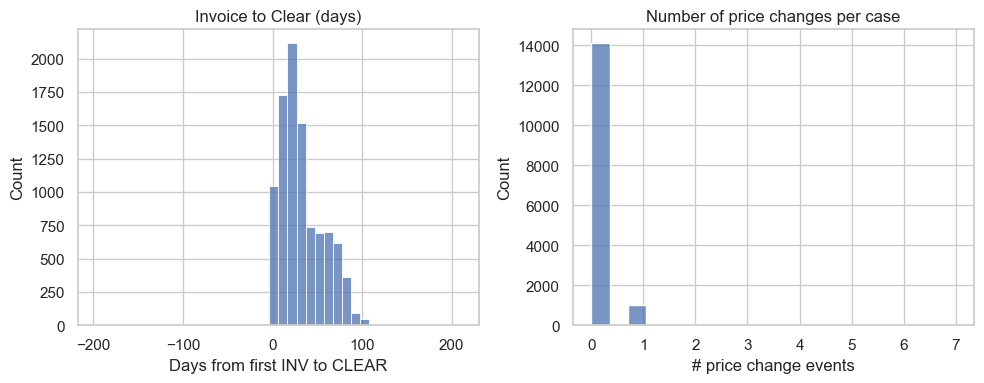

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(feat["inv_to_clear_days"], bins=40, kde=False)
plt.title("Invoice to Clear (days)")
plt.xlabel("Days from first INV to CLEAR")

plt.subplot(1,2,2)
sns.histplot(feat["n_price_changes"], bins=20, kde=False)
plt.title("Number of price changes per case")
plt.xlabel("# price change events")
plt.tight_layout()
plt.show()

**Business interpretation.**

- Long tails in `inv_to_clear_days` indicate **blocked or delayed invoices**.  
- High `n_price_changes` suggests **rework** and potential process or contracting
  issues, especially if concentrated in certain spend areas or vendors.

---

## 5. Compute WISE case scores for the subset

Using the BPIC norm (`WISE_BPIC_Norm.json`) and a selected view (e.g.
**Finance**), we can compute WISE scores for each case in this subset.

In [10]:
view_name = "Finance"
case_scores = compute_wise_case_scores(
    df_example=df_example,
    norm_path=paths["norm_path"],
    view_name=view_name,
    case_id_col=case_id_col,
    act_col=act_col,
    ts_col=ts_col,
)

save_df(case_scores, "case_scores_3-way_match_invoice_after_GR.csv")

case_scores.head(20)

,case concept:name,score,violation_exclusion,violation_order_lag,violation_presence,violation_singularity,viol_c_l1_create_po,viol_c_l1_gr,viol_c_l1_inv,viol_c_l1_clear,...,viol_c_l2_inv_to_clear,viol_c_l4_change_price_once,viol_c_l4_change_quantity_once,viol_c_l4_change_currency_once,viol_c_l4_change_payment_terms_once,viol_c_l5_cancel_invoice,viol_c_l5_cancel_gr,viol_c_l5_subsequent_invoice,viol_c_l5_subsequent_credit,badness
0,2000000001_00001,0.916667,0.00,0.222222,0.00,0.00,0.0,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
1,2000000002_00001,0.850000,0.25,0.333333,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.150000
2,2000000005_00002,0.575000,0.00,1.000000,0.75,0.00,0.0,1.0,1.0,1.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425000
3,2000000006_00001,0.941667,0.00,0.155556,0.00,0.00,0.0,0.0,0.0,0.0,...,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058333
4,2000000008_00001,0.975000,0.00,0.066667,0.00,0.00,0.0,0.0,0.0,0.0,...,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025000
5,2000000009_00001,1.000000,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,2000000010_00001,0.800000,0.00,0.333333,0.00,0.25,0.0,0.0,0.0,0.0,...,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000
7,2000000011_00001,0.925000,0.00,0.333333,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075000
8,2000000013_00001,1.000000,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,2000000014_00001,1.000000,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


The resulting DataFrame contains at least:

- `case_id_col`,
- `score` (overall WISE score in `[0,1]`; higher = better),
- `badness = 1 - score` (higher = worse),
- violation metrics per layer, e.g. `violation_presence`, `violation_order_lag`,
  `violation_balance`, `violation_singularity`, `violation_exclusion`.

**Business meaning.**

- `score = 1` → the case behaves exactly as prescribed by the norm for this
  view and process type.  
- `score = 0.80` vs `score = 0.95` → the first case systematically violates
  more constraints (or more important ones) than the second.  
- Layer violations in `[0,1]` tell you which *type* of problem dominates
  for a given case: missing steps (L1), timing (L2), value mismatches (L3),
  rework (L4), or forbidden patterns (L5).

---

## 6. Enrich `case_full`: scores + features + slice attributes

We now combine WISE scores, engineered features, and slice attributes into
one table `case_full` that will be the basis for slice-level analysis and
plots.

In [11]:
case_full = enrich_case_full(
    case_scores=case_scores,
    feat=feat,
    df_example=df_example,
    case_id_col=case_id_col,
)
save_df(case_full, "case_full_3-way_match_invoice_after_GR.csv")
case_full.head()

,case concept:name,score,violation_exclusion,violation_order_lag,violation_presence,violation_singularity,viol_c_l1_create_po,viol_c_l1_gr,viol_c_l1_inv,viol_c_l1_clear,...,gr_to_inv_cluster,inv_to_clear_cluster,auto_level,complexity_score,complexity_cluster,throughput_days,throughput_cluster,start_season,start_weekpart,start_dayofweek
0,2000000001_00001,0.916667,0.00,0.222222,0.00,0.0,0.0,0.0,0.0,0.0,...,_5,_2,NaN,0.613284,_4,63.0,_4,Q1,weekday,Wed
1,2000000002_00001,0.850000,0.25,0.333333,0.00,0.0,0.0,0.0,0.0,0.0,...,_1,_5,NaN,0.663133,_4,223.0,_1,Q1,weekday,Thu
2,2000000005_00002,0.575000,0.00,1.000000,0.75,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,0.304213,_1,NaN,NaN,Q1,weekday,Mon
3,2000000006_00001,0.941667,0.00,0.155556,0.00,0.0,0.0,0.0,0.0,0.0,...,_5,_2,NaN,0.613284,_4,44.0,_5,Q1,weekday,Mon
4,2000000008_00001,0.975000,0.00,0.066667,0.00,0.0,0.0,0.0,0.0,0.0,...,_5,_2,NaN,0.504784,_3,44.0,_5,Q1,weekday,Mon


This table includes:

- WISE columns: `score`, `badness`, layer violations, etc.
- Features: lead times, counts, multiplicity, automation, behavioural cluster.
- Slices: `case Company`, `case Spend area text`, `case Item Category` (and
  speed/complexity/automation clusters derived inside `enrich_case_full`).fileciteturn9file0

At this point you can already do explorations like:

In [12]:
case_full.groupby("case Spend area text")["score"].describe().sort_values("mean")

,count,mean,std,min,25%,50%,75%,max
case Spend area text,,,,,,,,
Titanium Dioxides,7.0,0.711964,0.141281,0.575000,0.575000,0.725000,0.804375,0.925000
Logistics,4602.0,0.735631,0.128540,0.550000,0.650000,0.650000,0.869167,1.000000
CAPEX & SOCS,463.0,0.763996,0.127277,0.575000,0.650000,0.725000,0.925000,1.000000
Trading & End Products,868.0,0.812467,0.127823,0.575000,0.725000,0.800000,0.925000,1.000000
Marketing,454.0,0.815825,0.134445,0.575000,0.725000,0.822083,0.925000,1.000000
Enterprise Services,171.0,0.817220,0.150384,0.575000,0.650000,0.874167,0.942500,1.000000
Additives,351.0,0.830769,0.108431,0.575000,0.786042,0.875000,0.925000,1.000000
Solvents,38.0,0.835548,0.093346,0.575000,0.806250,0.873750,0.900208,0.925000
Spend Area Unidentified,25.0,0.838833,0.103150,0.575000,0.841667,0.875000,0.903333,0.925000


> **Question:** Which spend areas have consistently lower scores?
>  
> That is already a WISE-based signal of where the process under this view
> deviates from expectations.

---

## 7. Slice-level aggregation and WISE heatmaps

### 7.1. Aggregate scores over slices

We next aggregate scores over slices using `aggregate_slices`, which performs
Empirical-Bayes shrinkage to protect against small sample sizes.fileciteturn9file0

Choose the slice dimensions you care about. For example:

In [13]:
slice_cols = [
    "case Company",
    "case Spend area text",
    "case Item Category",
    "cluster",              # behavioural cluster from KMeans
    "complexity_cluster",   # from enrich_case_full
    "auto_level",           # automation bucket
]

slice_cols = [c for c in slice_cols if c in case_full.columns]

slice_summary = aggregate_slices(
    df_scores=case_full,
    slice_cols=slice_cols,
    score_col="score",
    shrink_k=50.0,
)
slice_summary = slice_summary.sort_values("shrunk_score")
save_df(slice_summary, "slice_summary_3-way_match_invoice_after_GR.csv")
slice_summary.head(20)

/Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/analysis/wise_bpic19_modular.py:685: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(slice_cols, dropna=False)


,case Company,case Spend area text,case Item Category,cluster,complexity_cluster,auto_level,n_cases,mean_score,shrunk_score
84,companyID_0000,Logistics,"3-way match, invoice after GR",1,_1,NaN,1006,0.641091,0.649511
86,companyID_0000,Logistics,"3-way match, invoice after GR",1,_3,NaN,1261,0.647351,0.653895
132,companyID_0000,Packaging,"3-way match, invoice after GR",1,_1,NaN,537,0.652210,0.666410
94,companyID_0000,Logistics,"3-way match, invoice after GR",3,_3,NaN,419,0.649463,0.667529
292,companyID_0000,NaN,"3-way match, invoice after GR",1,_1,NaN,79,0.598734,0.684078
20,companyID_0000,CAPEX & SOCS,"3-way match, invoice after GR",1,_1,NaN,164,0.645884,0.686313
180,companyID_0000,Sales,"3-way match, invoice after GR",1,_1,NaN,266,0.663647,0.688215
260,companyID_0000,Trading & End Products,"3-way match, invoice after GR",1,_1,NaN,234,0.670481,0.696615
85,companyID_0000,Logistics,"3-way match, invoice after GR",1,_2,NaN,101,0.641832,0.700470
100,companyID_0000,Marketing,"3-way match, invoice after GR",1,_1,NaN,104,0.652380,0.706451


Each row in `slice_summary` represents a **segment of the business** (e.g.
`Company A / Logistics / 3-way after GR / low automation / high complexity`)
with:

- `n_cases` – how many cases belong to the slice,
- `mean_score` – average raw WISE score,
- `shrunk_score` – mean score adjusted towards the global mean depending on
  volume.

### 7.2. Visualising top/bottom slices

Example: show the **lowest scoring** slices for Finance view.

In [14]:
top_bad = slice_summary.head(15)
top_bad

,case Company,case Spend area text,case Item Category,cluster,complexity_cluster,auto_level,n_cases,mean_score,shrunk_score
84,companyID_0000,Logistics,"3-way match, invoice after GR",1,_1,NaN,1006,0.641091,0.649511
86,companyID_0000,Logistics,"3-way match, invoice after GR",1,_3,NaN,1261,0.647351,0.653895
132,companyID_0000,Packaging,"3-way match, invoice after GR",1,_1,NaN,537,0.652210,0.666410
94,companyID_0000,Logistics,"3-way match, invoice after GR",3,_3,NaN,419,0.649463,0.667529
292,companyID_0000,NaN,"3-way match, invoice after GR",1,_1,NaN,79,0.598734,0.684078
20,companyID_0000,CAPEX & SOCS,"3-way match, invoice after GR",1,_1,NaN,164,0.645884,0.686313
180,companyID_0000,Sales,"3-way match, invoice after GR",1,_1,NaN,266,0.663647,0.688215
260,companyID_0000,Trading & End Products,"3-way match, invoice after GR",1,_1,NaN,234,0.670481,0.696615
85,companyID_0000,Logistics,"3-way match, invoice after GR",1,_2,NaN,101,0.641832,0.700470
100,companyID_0000,Marketing,"3-way match, invoice after GR",1,_1,NaN,104,0.652380,0.706451


Plot:

/var/folders/gx/8kpsm061237f1s5818mm_b5w0000gn/T/ipykernel_50245/3580789990.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_bad["shrunk_score"], y=labels, orient="h", palette="Reds_r")


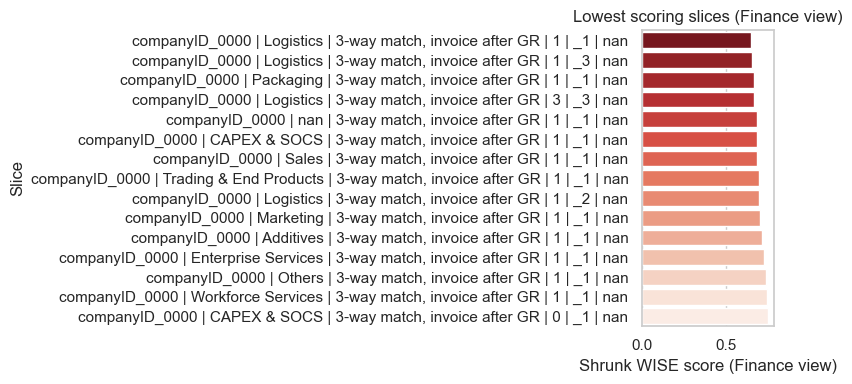

In [15]:
plt.figure(figsize=(8,4))
labels = top_bad[slice_cols].astype(str).agg(" | ".join, axis=1)
sns.barplot(x=top_bad["shrunk_score"], y=labels, orient="h", palette="Reds_r")
plt.xlabel("Shrunk WISE score (Finance view)")
plt.ylabel("Slice")
plt.title("Lowest scoring slices (Finance view)")
plt.tight_layout()
plt.show()

**Business interpretation.**

Slices at the bottom of this chart are **where the process deviates most from
the norm**, adjusted for volume. As process owner, you would ask:

- Which spend areas (Logistics, Services, Marketing) appear frequently at the
  bottom?  
- Are problematic slices highly manual, high complexity, and long lead time
  (`auto_level = _1`, `complexity_cluster = _4`, `throughput_cluster = _1`)?  
- Are some companies systematically better/worse than others?

These slices become prime candidates for **actionable problem statements**
(e.g. *“In Company X, Logistics 3-way items show low Finance scores and high
rework/late changes, especially in cluster _4 of complexity.”*).

### 7.3. Layer × slice heatmap

To understand **what kind of problems** dominate in each slice, you can
compute layer-level means and visualise them.

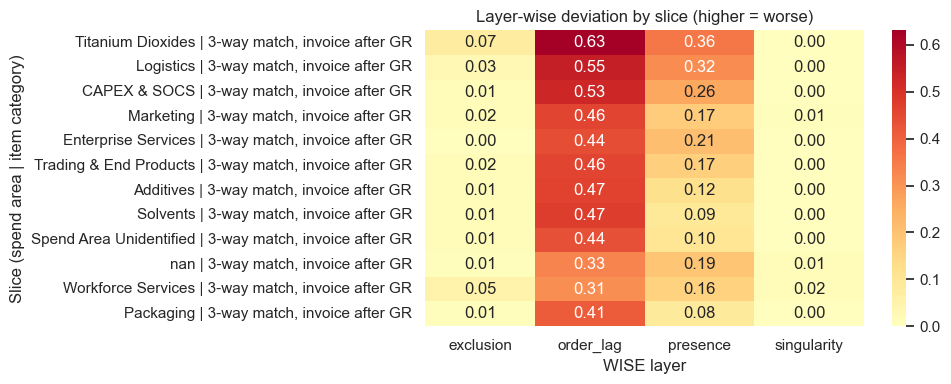

In [16]:
layer_cols = [c for c in case_full.columns if c.startswith("violation_")]

# Build a simpler slice key for illustration
case_full["slice_key"] = (
    case_full["case Spend area text"].astype(str)
    + " | "
    + case_full["case Item Category"].astype(str)
)

# Compute mean layer violations per slice
layer_means = (
    case_full.groupby("slice_key")[layer_cols]
    .mean()
    .reset_index()
)

# Select top N worst slices by average badness
layer_means["mean_badness"] = layer_means[layer_cols].mean(axis=1)
top_slices = (
    layer_means.sort_values("mean_badness", ascending=False)
    .head(12)
    .copy()
)

heat_data = top_slices.set_index("slice_key")[layer_cols]
heat_data.columns = [c.replace("violation_", "") for c in heat_data.columns]

plt.figure(figsize=(10,4))
sns.heatmap(heat_data, cmap="RdYlGn_r", center=0, annot=True, fmt=".2f")
plt.xlabel("WISE layer")
plt.ylabel("Slice (spend area | item category)")
plt.title("Layer-wise deviation by slice (higher = worse)")
plt.tight_layout()
plt.show()

**Business interpretation.**

For each of the worst slices, the heatmap shows whether the main problem is:

- **L1 Presence** – missing key steps (e.g. missing GR/INV/CLEAR),  
- **L2 Order/Lag** – late GR, late CLEAR, long GR→INV or INV→CLEAR intervals,  
- **L3 Balance** – value mismatches between PO/GR/INV,  
- **L4 Singularity** – repeated approvals, repeated price changes, too many GRs,  
- **L5 Exclusion** – forbidden changes after GR or after CLEAR.

For example, you might see:

> - *Logistics | 3-way after GR*: high L3 and L4 violations → value mismatches and lots of rework.  
> - *Enterprise Services | 2-way*: high L2 → late invoicing and clearing.  
> - *Marketing | 3-way before GR*: high L5 → price changes after GR and late corrections.

This is exactly the kind of **norm-based, typed explanation** that WISE is
designed to provide.

---

## 8. From analysis to explanation: where are the problems?

At this point the notebook has taken you from:

1. Raw event log →
2. Process models per process type →
3. Case-level KPIs and behavioural clusters →
4. WISE case scores (layered norm) →
5. Slice-level rankings and layer×slice heatmaps.

To summarise for stakeholders, you can construct short narratives such as:

- **Slice:** `Company A / Logistics / 3-way after GR / low automation`  
  - **Volume:** 25k cases per year (~18% of dataset).  
  - **WISE Finance score:** 0.78 (vs global 0.90), shrunk due to large volume.  
  - **Dominant layers:**  
    - L3 Balance – frequent mismatch between GR and INV quantities,  
    - L4 Singularity – multiple GRs and repeated price changes for the same PO line.  
  - **Likely impact:** higher manual effort in invoice resolution and risk of
    write-offs or disputes.

- **Slice:** `Company B / Enterprise Services / 2-way / complexity_cluster=_4`  
  - **Volume:** 8k cases.  
  - **WISE Finance score:** 0.81 (moderate).  
  - **Dominant layers:** L2 Order/Lag – long INV→CLEAR times; L1 Presence – some missing CLEAR events.  
  - **Likely impact:** blocked invoice days, delayed supplier payments.

These statements can be directly used in a backlog of improvement initiatives.
They can be tracked over time by re-running the WISE pipeline and comparing
slice scores between periods.

---

### Improvement backlog (Finance view, 3-way after GR)

1. **Logistics – price changes after GR (L4/L5)**  
   - Evidence: low shrunk score, high L4/L5 in heatmaps; SHAP/LIME show `n_price_changes` as top driver.  
   - Action: review policy on price changes; enforce approval workflow earlier; align contracts.

2. **Logistics – fragmented GRs and long GR→INV time (L2/L3)**  
   - Evidence: high `n_gr`, long `gr_to_inv_days`.  
   - Action: consolidate GR postings; automate GR for recurring flows; monitor GR timeliness.

3. **CAPEX & SOCS – long INV→CLEAR (L2)**  
   - Evidence: high `inv_to_clear_days`, moderate L2 violation.  
   - Action: streamline approval chain; add automated reminders and WISE-based KPIs.

4. **High-complexity, low-automation clusters**  
   - Evidence: cluster×auto heatmap, SHAP importance of `auto_ratio`.  
   - Action: develop automation roadmap, starting with slices that have good scores at medium automation (low regression risk).





## 9. Extending to other process types and views

The same pattern can be repeated for:

- **3-way before GR** (invoice arrives before GR; norm emphasises L2 and L5
  around blocks/unblocks and GR arrival),  
- **2-way match** (no GR; norm focuses on L3 balance and L4/L5 rework/late changes),  
- **Consignment** (GR but no invoice in this log; norm may emphasise L1/L3
  around GR and consignment-specific events).

For each process type you can:

1. Call `subset_by_item_category` with the appropriate label.
2. Run `build_case_features` and `compute_wise_case_scores`.
3. Use `enrich_case_full` and `aggregate_slices` with the same slice
   dimensions.
4. Compare findings across types and views (Finance vs Logistics vs Automation).

This modular design (central WISE norm + reusable helper functions) lets you
turn BPIC'19 from a one-off challenge into a **reusable template** for
norm-based, slice-first P2P analysis in other organisations.